# **GPU Demo Part 2 - Decoupler-GPU: Accelerated Transcriptional Regulatory Analysis**  

**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

**Please run [GPU Demo Part 1 - Basic GPU E2E Workflow](01_demo_gpu_e2e.ipynb) before running this notebook as this notebook continues some analysis of that notebook's output.**

In this notebook, we explore the updated **Decoupler** functions for inferring transcriptional regulatory activity, leveraging the **GPU-accelerated** implementation from **rapids-singlecell**.  

By running these analyses on GPUs, we achieve **faster computation** and **scalability** for large single-cell datasets. We will apply **Decoupler** methods to estimate **transcription factor (TF) activity** and **pathway activity**, utilizing curated regulatory networks such as **Dorothea** and **PROGENy**.

In [1]:
import rapids_singlecell as rsc
import scanpy as sc
import rmm
import cupy as cp
import pandas as pd
import decoupler as dc
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=True, # default is False
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [2]:
adata = sc.read_h5ad("./h5/dli_decoupler.h5ad")

In [3]:
adata = adata.raw.to_adata()

In [4]:
rsc.get.anndata_to_GPU(adata)

### Retrieving Transcription Factor (TF) Regulons with Dorothea  

We start by retrieving the **Dorothea** gene regulatory network, which provides curated transcription factor (TF) target interactions.  
Dorothea assigns confidence levels (`A`, `B`, `C`, `D`, `E`), where `A` represents the highest confidence interactions.  
Here, we filter for **high-confidence** (`A`, `B`, `C`) interactions in human data:  

In [5]:
net = pd.read_parquet("nets/dorothea.parquet")

### Transcription Factor Activity Inference with ULM  

To infer transcription factor (TF) activity, we use the **Univariate Linear Model (ULM)** from **Decoupler**.  
ULM estimates the regulatory influence of TFs on gene expression by fitting a linear model for each TF-gene interaction.  

We apply **ULM** using the **Dorothea** regulatory network retrieved earlier. 

In [6]:
%%time
rsc.dcg.run_ulm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True, use_raw = False, pre_load=True)

Running ulm on mat with 213082 samples and 28065 targets for 296 sources.


  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 12.6 s, sys: 189 ms, total: 12.8 s
Wall time: 12.6 s


In [7]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

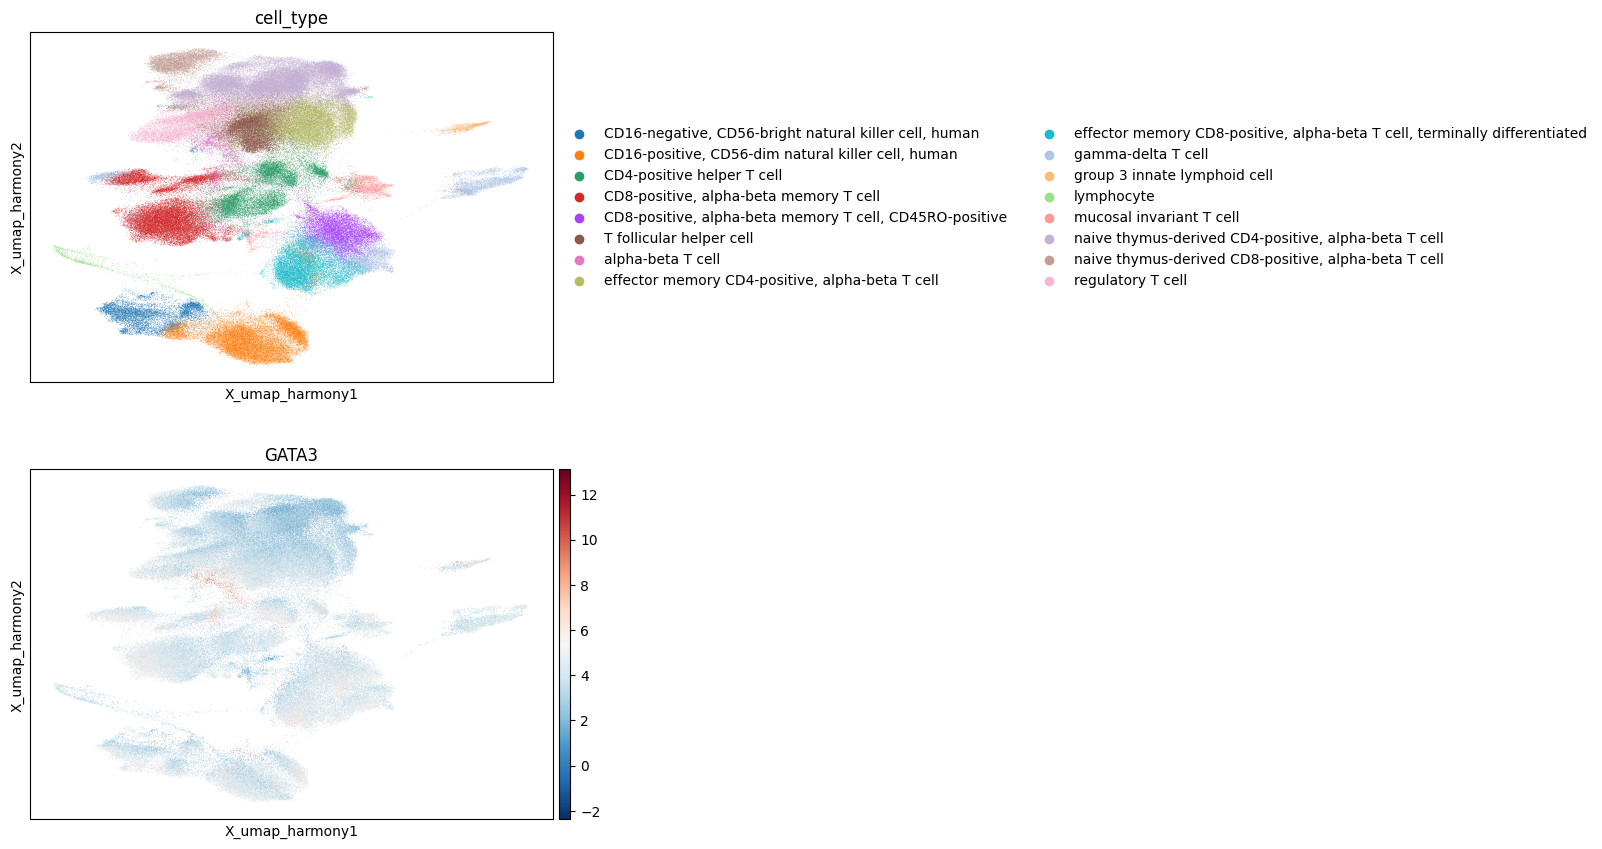

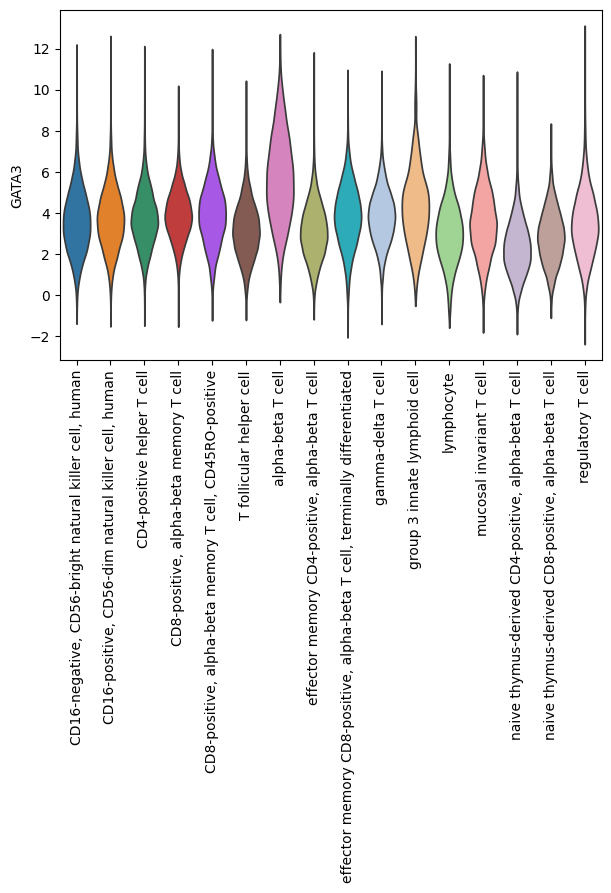

In [8]:
sc.pl.embedding(acts,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(acts, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


### Transcription Factor Activity Inference with MLM  

Next, we infer transcription factor (TF) activity using the **Multivariate Linear Model (MLM)** from **Decoupler**.  
Unlike **ULM**, which considers each TF independently, **MLM** accounts for multiple TFs simultaneously,  
providing a more comprehensive estimation of regulatory influences. 

In [9]:
%%time
rsc.dcg.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True, use_raw = False, pre_load=True)

Running mlm on mat with 213082 samples and 28065 targets for 296 sources.


  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 13 s, sys: 340 ms, total: 13.4 s
Wall time: 13.2 s


### Transcription Factor Activity Inference with AUCell  

Next, we infer transcription factor (TF) activity using **AUCell** from **Decoupler**.  
AUCell estimates TF activity based on the **enrichment of TF target genes within the top-expressed genes** in each cell.  
Unlike regression-based methods (**ULM**, **MLM**), AUCell is a **rank-based approach** that does not assume linear relationships. 

In [10]:
%%time
rsc.dcg.run_aucell(mat=adata, net=net, source='source', target='target', verbose=True, use_raw = False, pre_load=True)

Running aucell on mat with 213082 samples and 28065 targets for 296 sources.


  0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 31.7 s, sys: 208 ms, total: 31.9 s
Wall time: 31.7 s


In [11]:
acts = dc.get_acts(adata, obsm_key='aucell_estimate')

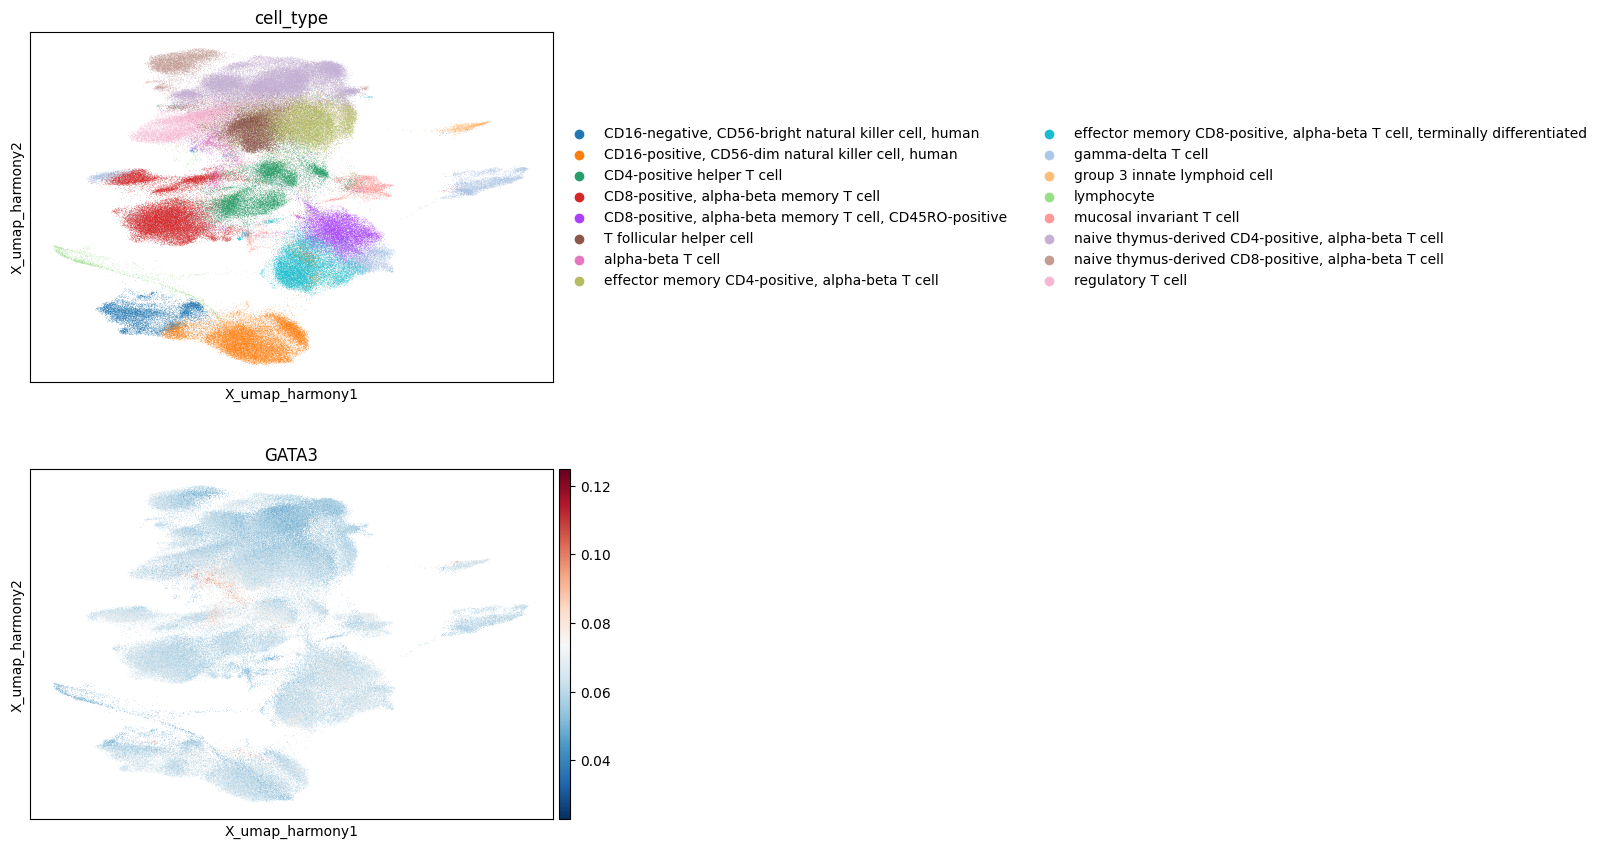

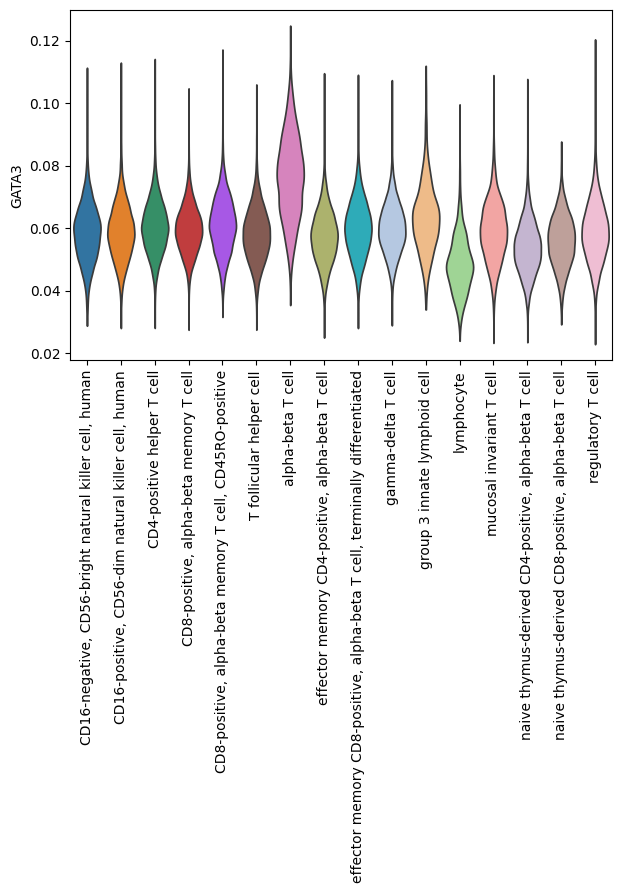

In [12]:
sc.pl.embedding(acts,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(acts, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


### Retrieving Pathway Activity Models with PROGENy  

To assess pathway activity, we use **PROGENy**, a curated model that links gene expression to pathway activity scores.  
PROGENy provides a **data-driven** approach to infer the activity of major signaling pathways  
by leveraging transcriptional signatures derived from perturbation experiments.  

We retrieve the **top 100 most informative target genes** for each pathway in **human** data  

In [13]:
model = pd.read_parquet("nets/progeny.parquet")

### Pathway Activity Inference with Weighted Sum (WSUM)  

Next, we infer pathway activity using the **Weighted Sum (WSUM)** method from **Decoupler**.  
WSUM estimates pathway activity by computing a **weighted sum of target gene expression values**,  
where gene weights reflect their importance in the pathway model (e.g., from PROGENy).  

In [14]:
%%time
rsc.dcg.run_wsum(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True, use_raw = False, pre_load=True)

Running wsum on mat with 213082 samples and 28065 targets for 14 sources.


  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 37.7 s, sys: 40.3 ms, total: 37.7 s
Wall time: 37.7 s
